In [1]:
%reload_ext autoreload
%reload_ext line_profiler
%autoreload 2

In [1]:
from multiprocessing import Pool
import experiments
import pickle 
import os 
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from functools import partial

%matplotlib inline

In [2]:
N = 10000
wsqs = (10,50)
tvs = (0.05, 0.5)

if __name__ ==  '__main__': 
    num_processors = 4
    #p=Pool(processes = num_processors)
    #output = p.starmap(experiments.width_experiment,[(N,wsq,tv) for wsq in wsqs for tv in tvs])
    #print(output)

for wsq in wsqs:
    for tv in tvs:
        #pointwise_asym = experiments.evaluate(f'widthpointasym_{wsq}_{tv}.pkl', experiments.pointwise_asym_ci, alpha=0.05, ndata=N, reps=2, wsq=wsq, tv=tv)
        supermartingale = experiments.evaluate(f'widthsupermartingale_{wsq}_{tv}.pkl', experiments.cs_via_supermartingale, alpha=0.05, ndata=N, reps=4, wsq=wsq, tv=tv)
        #supermartingale = experiments.evaluate(f'widthsupermartingale1d_{wsq}_{tv}.pkl', experiments.cs_via_supermartingale_1d, alpha=0.05, ndata=N, reps=4, wsq=wsq, tv=tv)
        #supermartingale = experiments.evaluate(f'widthEWA_{wsq}_{tv}.pkl', experiments.cs_via_EWA_debug, alpha=0.05, ndata=N, reps=2, wsq=wsq, tv=tv)


/mnt/c/Users/v-zmhammedi/Documents/Reseach/Off-policy-learning/code/mope/cs_via_supermartingale.py:226: RuntimeWarning: divide by zero encountered in double_scalars
  gamma[1]=(-rho(alpha) - Cv * Sigma * S)/den
/mnt/c/Users/v-zmhammedi/Documents/Reseach/Off-policy-learning/code/mope/cs_via_supermartingale.py:238: RuntimeWarning: divide by zero encountered in double_scalars
  gamma[0]=(-rho(alpha) - Cv * Sigma * S)/den


(10000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.2169, 'widthstd': 0.0122, 'widthlo': 0.1968, 'widthhi': 0.2388, 'ub': 0.2466, 'lb': 0.0297})
(10000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.295, 'widthstd': 0.0182, 'widthlo': 0.2587, 'widthhi': 0.3235, 'ub': 0.7069, 'lb': 0.4119})
(10000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.2418, 'widthstd': 0.0268, 'widthlo': 0.1867, 'widthhi': 0.277, 'ub': 0.2722, 'lb': 0.0305})
(10000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.5802, 'widthstd': 0.1243, 'widthlo': 0.3485, 'widthhi': 0.7973, 'ub': 0.8831, 'lb': 0.3028})


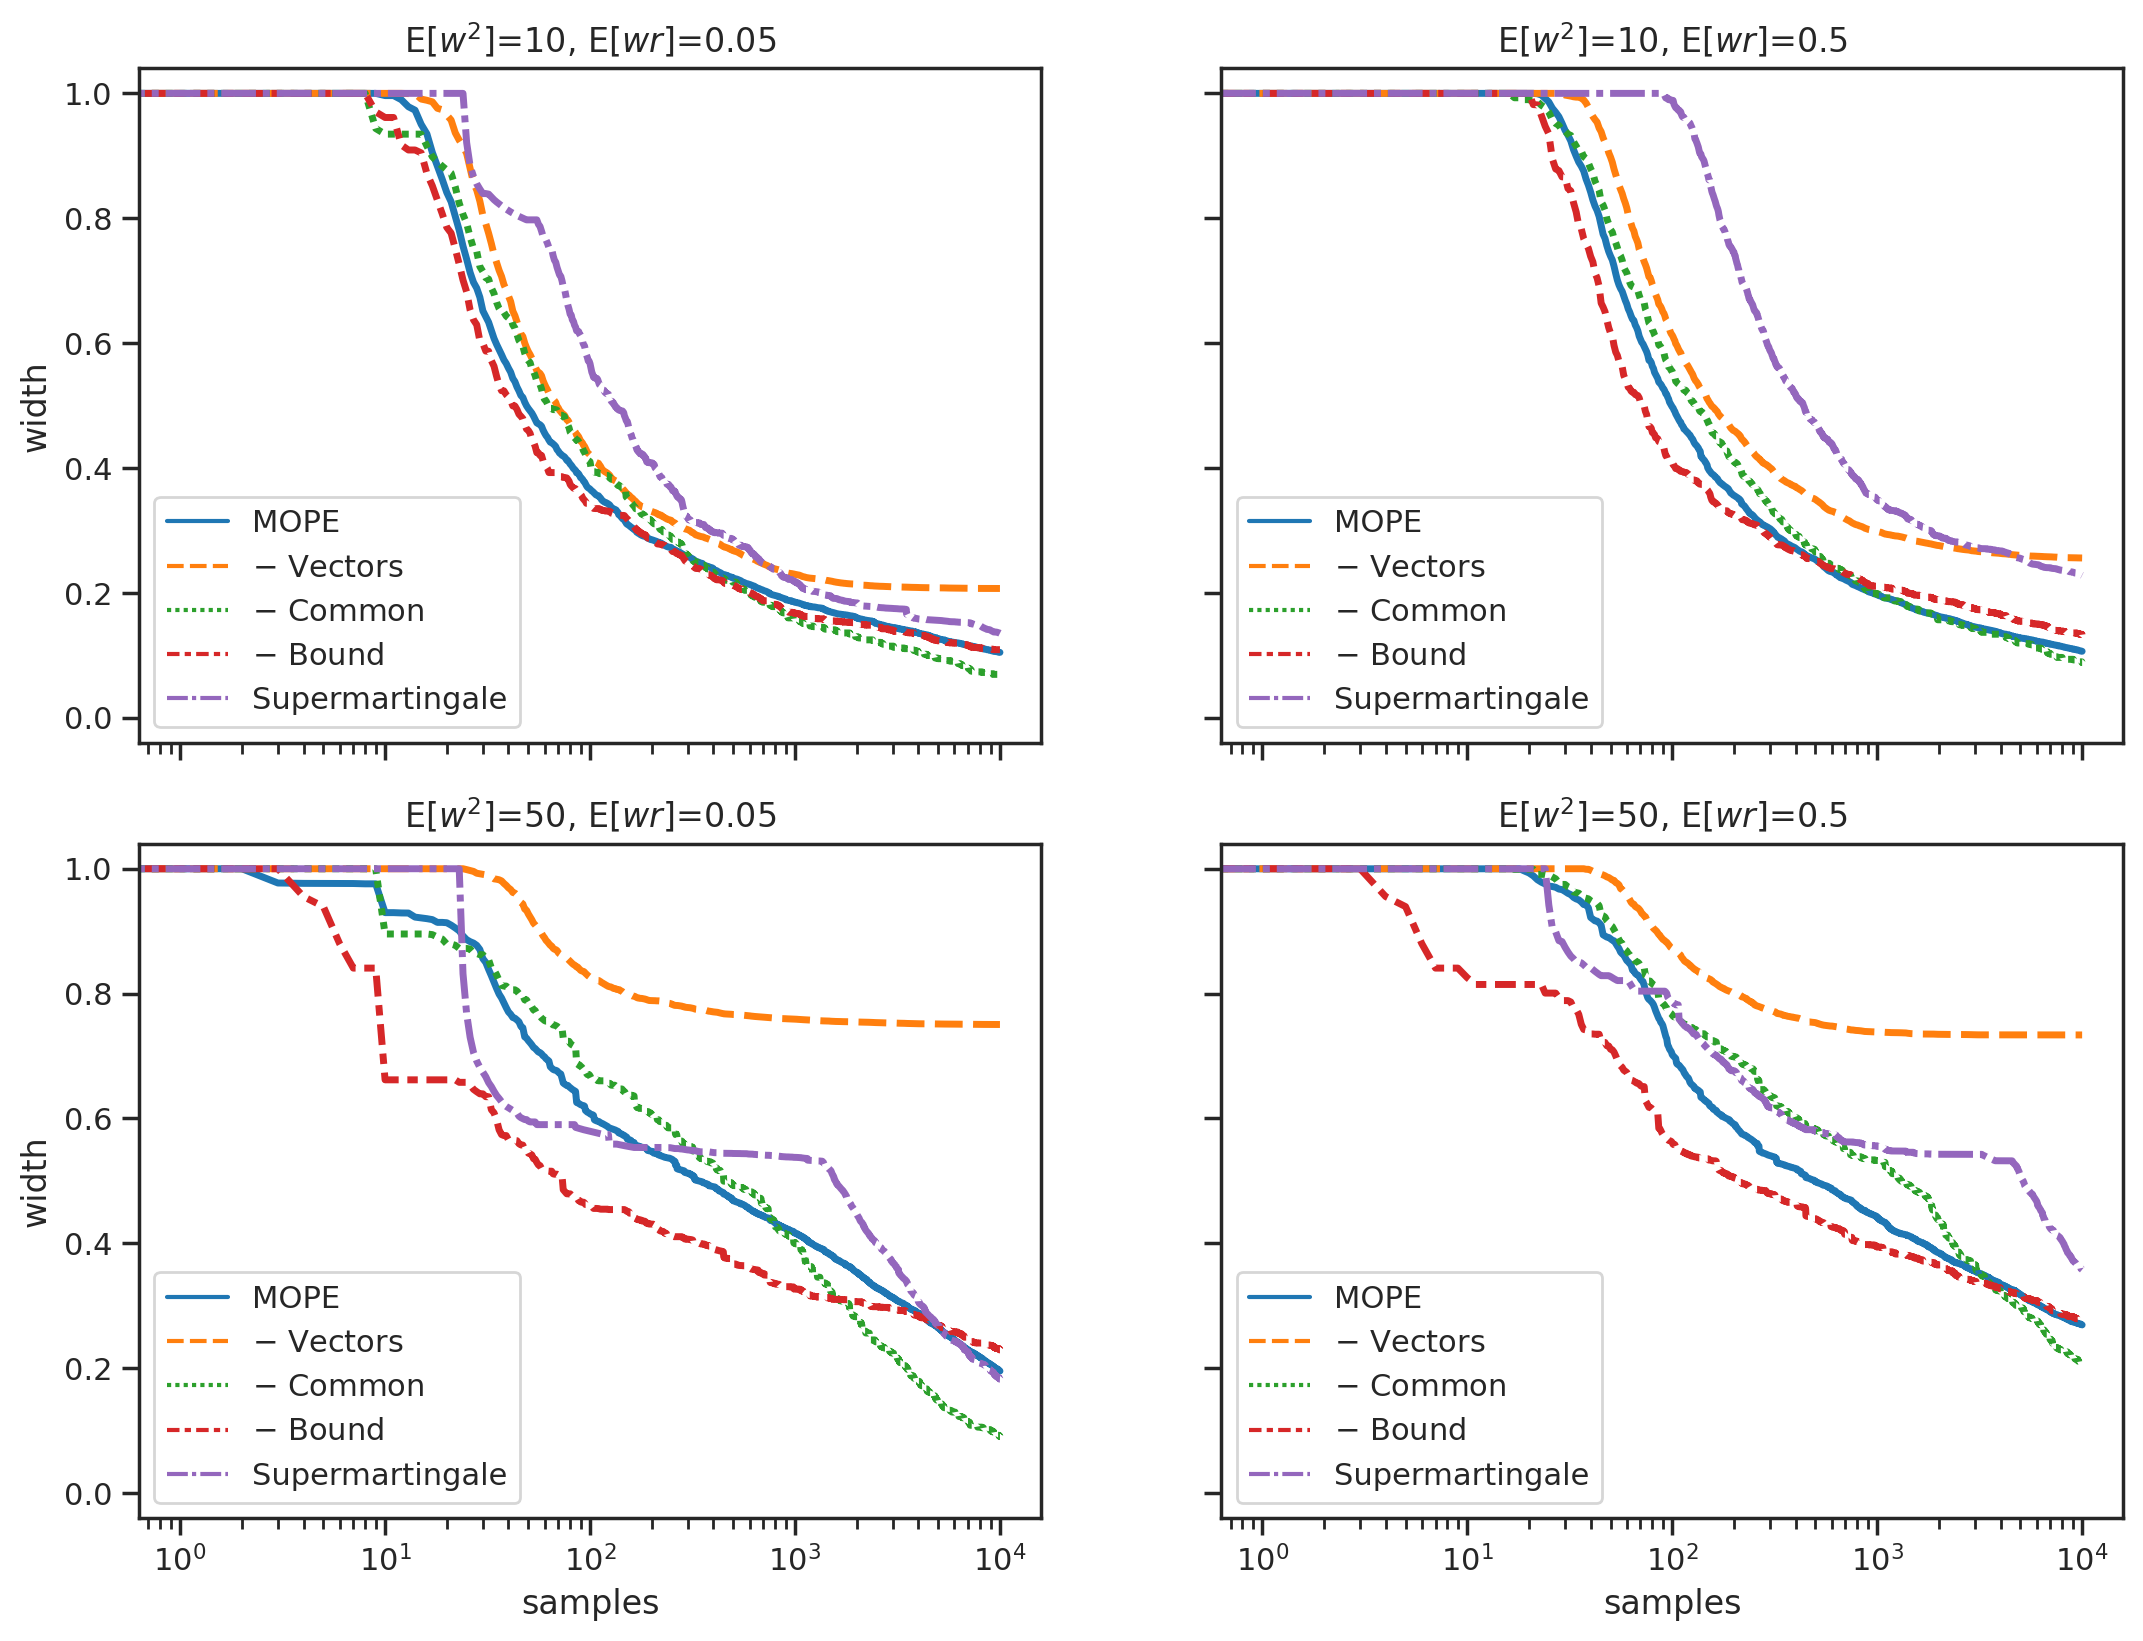

In [5]:
legend = {'2d': 'MOPE', '1d': '$-$ Vectors', 'iqp': '$-$ Common', 'log': '$-$ Bound','supermartingale': 'Supermartingale'} # 'supermartingale1d': 'Supermartingale 1d'
fig, ax = plt.subplots(2,2, sharex='col', sharey='row', figsize=(12.8, 9.6), dpi=200, gridspec_kw={'hspace': 0.15})
for i,wsq in enumerate((10, 50)):
    for j,tv in enumerate((0.05, 0.5)):
        d = {}
        for method in '2d','1d','iqp','log','supermartingale': #'supermartingale1d'
            name = f'width{method}_{wsq}_{tv}.pkl'
            with open(name, 'rb') as pkl:
                d[legend[method]] = pickle.load(pkl)[1]['width']
        experiments.plotit(d,f'E[$w^2$]={wsq}, E[$wr$]={tv}', ax=ax[i,j])
ax[0,0].set(xscale="log")
ax[0,1].set(xscale="log")
ax[0,0].legend(loc='lower left')
ax[0,1].legend(loc='lower left')
#fig.savefig('width.pdf', bbox_inches='tight', pad_inches=0)

# Some debugging

In [106]:
from cs_via_supermartingale import bisection_algorithm, rho, log_supermartingale_value, log_supermartingale_value_slow, linear_search, martingale_value_lowerbound
#martval0 = lambda v: supermartingale_value(v,100,b0,b1,A0,A1,A2)


b0=np.array([-9.5,5.0])
b1=np.array([0.0,-316.0])
A0=np.array([[243.25,0.5],[0.5,5.5]])
A1=np.array([[0.0,9.5],[9.5,-10.0]])
A2=np.array([[0.0,0.0],[0.0,316.0]])
logmartval_slow = lambda v: log_supermartingale_value_slow(v,100,b0,b1,A0,A1,A2)
logmartval = lambda v: log_supermartingale_value(v,100,b0,b1,A0,A1,A2)
#tmpv = linear_search(martval0,0,1,-np.log(2 * 0.05),step=0.0001)
mu = 1

I = np.identity(2)
J = np.array([1,1,1])

Cv = lambda v: np.array([[-1,100-1,100-1],[-v,-v,100-v]])
    
S = lambda v: b0 + b1 * v
Q = lambda v: A0 + A1 * v + A2 * v**2 

Stilde = lambda v, gamma: S(v) + Cv(v) @ gamma
Sigma = lambda v: np.linalg.inv(2 * pow(mu,-2) * I + 2 *Q(v)) # TODO Make this more efficient via Sherman Morison
cost = lambda v, gamma: Stilde(v,gamma).T @ Sigma(v) @ Stilde(v,gamma)/2 + rho(2)*gamma.T @ J  -  np.log(np.sqrt(np.linalg.det(I + pow(mu,2)*Q(v))))

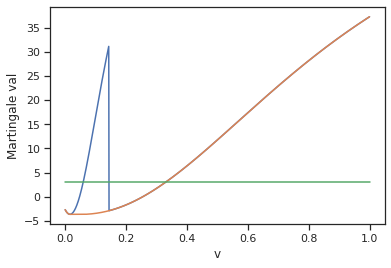

In [107]:
# Trying to plot as a function of v
Nv = 1000
grid_v =np.linspace(0,1,Nv)
mvalues = np.zeros(Nv)
mvalues_slow = np.zeros(Nv)

for i, v in enumerate(grid_v):
    mvalues_slow[i]=logmartval_slow(v)
    mvalues[i]=logmartval(v)
plt.plot(grid_v,mvalues)
plt.plot(grid_v,mvalues_slow)
lalpha = -np.log(0.05) * np.ones(Nv)
plt.plot(grid_v,lalpha)

plt.xlabel("v")
plt.ylabel("Martingale val")
plt.show()

In [85]:
print(logmartval_slow(0.1))
print(logmartval(0.1))
print(cost(0.1,np.array([0., 0.08261228, 0.])))

gamma=[-1.74364705e-23  2.08051682e-23  2.47585662e-01]
-3.6355718663834793
gamma=[0.         0.08261228 0.        ]
14.641208509587257
14.641208509587257
